# Source:

Tiago A. Almeida (talmeida ufscar.br)
Department of Computer Science
Federal University of Sao Carlos (UFSCar)
Sorocaba, Sao Paulo - Brazil

R&D Department Optenet
Las Rozas, Madrid - Spain


# Data Set Information:

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages.
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available.
- A list of 450 SMS ham messages collected from Caroline Tag's PhD.
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages .

# Attribute Information:

The collection is composed by just one text file, where each line has the correct class followed by the raw message. We offer some examples bellow:

- ham What you doing?how are you?
- ham Ok lar... Joking wif u oni...
- ham dun say so early hor... U c already then say...
- ham MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*
- ham Siva is in hostel aha:-.
- ham Cos i was out shopping wif darren jus now n i called him 2 ask wat present he wan lor. Then he started guessing who i was wif n he finally guessed darren lor.
- spam FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! ubscribe6GBP/ mnth inc 3hrs 16 stop?txtStop
- spam Sunshine Quiz! Win a super Sony DVD recorder if you canname the capital of Australia? Text MQUIZ to 82277. B
- spam URGENT! Your Mobile No 07808726822 was awarded a L2,000 Bonus Caller Prize on 02/09/03! This is our 2nd attempt to contact YOU! Call 0871-872-9758 BOX95QU


# Step 1: Getting Things Ready

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import WordCloud,STOPWORDS 

In [2]:
df=pd.read_csv("data/SMSSpamCollection",sep="\t", names=["type","text"])
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Step 2: EDA

In [3]:
df.shape

(5572, 2)

**We have kind of a lots of data, if we are considering text-tual information**

In [4]:
df.info

<bound method DataFrame.info of       type                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [5]:
df["type"].value_counts()

ham     4825
spam     747
Name: type, dtype: int64

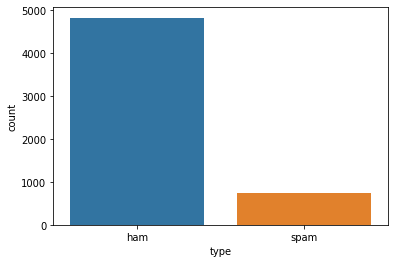

In [6]:
sb.countplot(x='type', data=df)

**So the data is kind of "Imbalanced" in trend, 'not spam' messages are more as compared to 'spam'.**

**I would be considering to classify either messages are 'spam' or not, which would be better considering the trend of data**

In [7]:
sum(len(i) for i in df['text'])

448490

**So, we have 4,48,490 characters to process**

In [8]:
ham_df=df.loc[df.type=="ham",'text']
spam_df=df.loc[df.type=="spam",'text']
HAM_words=' '.join(ham_df)
SPAM_words=' '.join(spam_df)

**So, we are having text emojis, words with special characters (&,#) and numbers which seem to be removed too, before training models on this data...**

In [9]:
wordcloud_ham = WordCloud(stopwords=STOPWORDS,background_color='black',width=1000,height=500).generate(HAM_words)

wordcloud_spam=WordCloud(stopwords=STOPWORDS,background_color='black',width=1000,height=500).generate(SPAM_words)

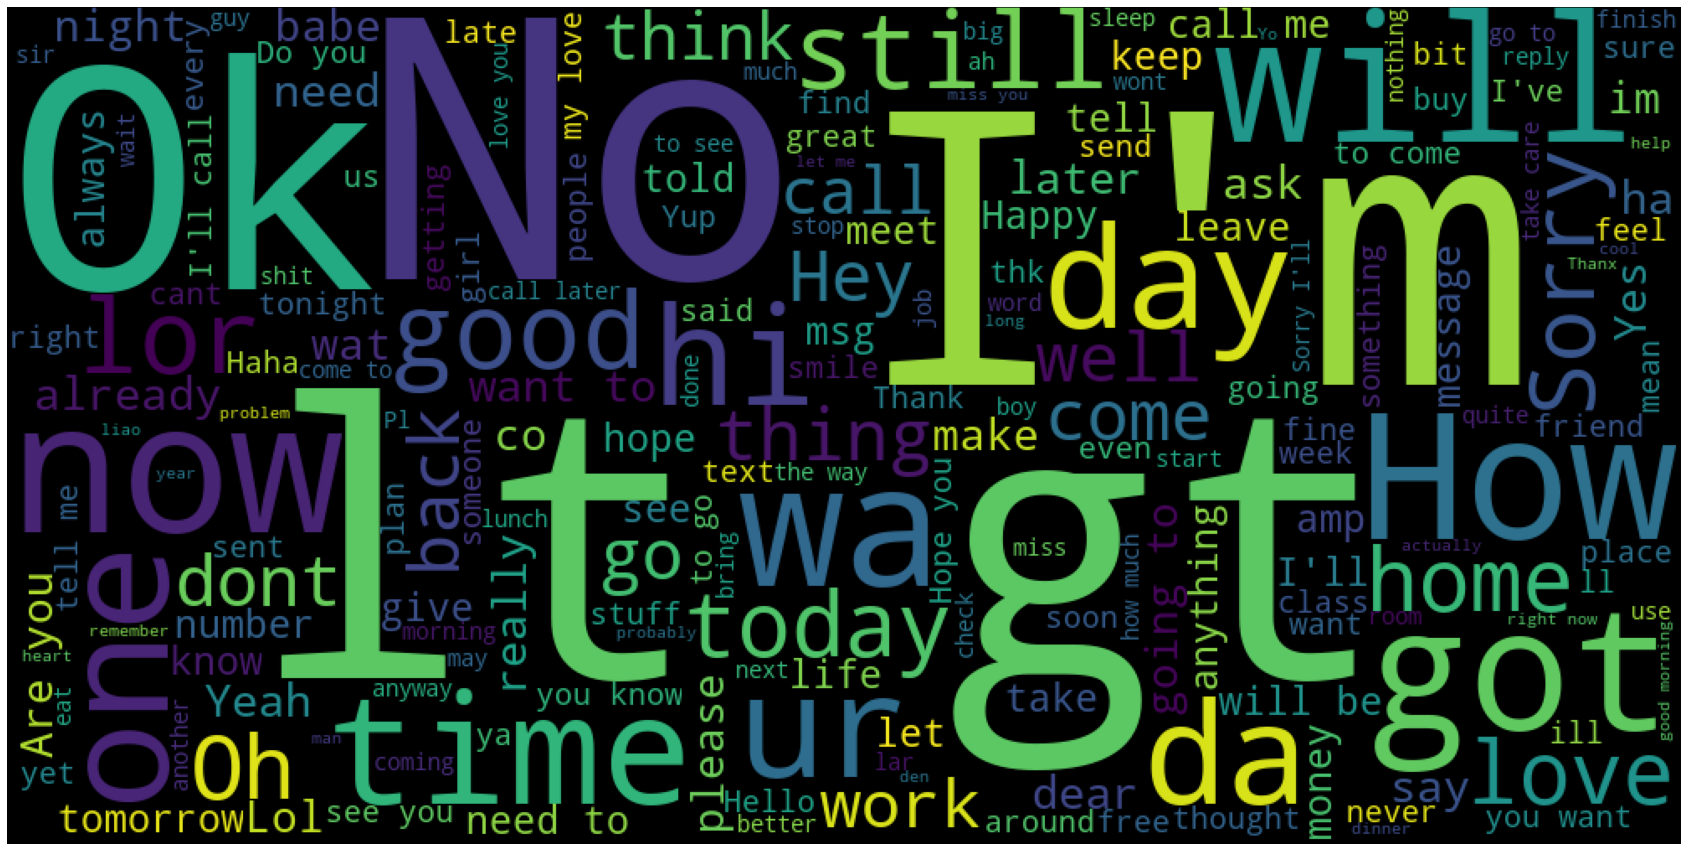

In [10]:

plt.figure(1,figsize=(30,20))
plt.imshow(wordcloud_ham)
plt.axis('off')
plt.show()

**Utillization of words like ok, now, time ,day, etc is very much huge in emails envolving 'ham' or 'no spam' messages in this dataset**

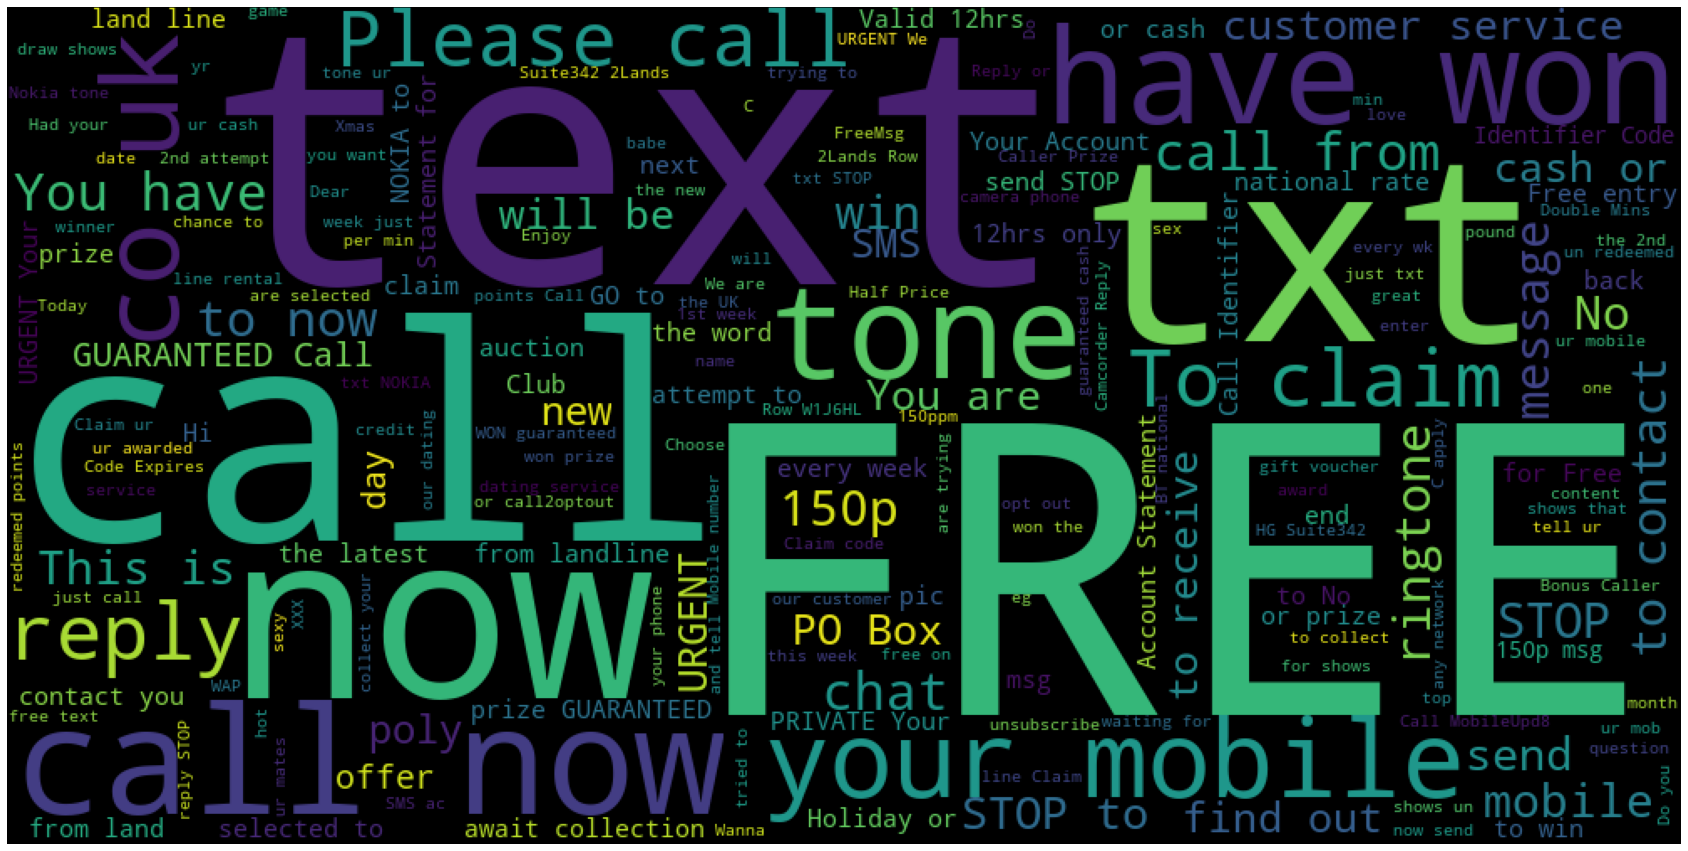

In [11]:
plt.figure(1,figsize=(30,20))
plt.imshow(wordcloud_spam)
plt.axis('off')
plt.show()

**Utillization of words like Free, text, call ,cash, etc is very much huge in emails envolving 'spam' messages in this dataset, most of the messages tend to present attribute to sell something to the reciever**

# Step 3: Data Preprocessing

In [12]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [13]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()
lemma=WordNetLemmatizer()

def preprocess(raw_tweet,setting):
    #regex to remove all characters except alphabets 
    clean = re.sub("[^a-zA-Z]", " ",raw_tweet)
    
    #regex to remove all repeating sequence of letters
    clean= re.sub(r'([a-z])\1+', r'\1',clean)
    
    # change sentence to lower case
    clean = clean.lower()

    # tokenize into words
    words = clean.split()
    
    # remove stop words                
    words = [w for w in words if not w in stopwords.words("english")]
    
    if setting=='stem':
        #Stemming
        words = [stemmer.stem(word) for word in words]
    else:
        words=[lemma.lemmatize(word) for word in words]
    
    return(" ".join(words))

In [14]:
from tqdm import tqdm
tqdm.pandas()

In [15]:
df['spam']=df['type'].progress_apply(lambda x:1 if x=='spam' else 0)

100%|██████████| 5572/5572 [00:00<00:00, 93530.91it/s]


In [16]:
df['clean_text_stem']=df['text'].progress_apply(lambda x: preprocess(x,'stem'))

100%|██████████| 5572/5572 [01:15<00:00, 73.69it/s] 


In [17]:
df['clean_text_lemma']=df['text'].progress_apply(lambda x: preprocess(x,'lemma'))

100%|██████████| 5572/5572 [01:18<00:00, 70.78it/s] 


In [18]:
df.head()

,type,text,spam,clean_text_stem,clean_text_lemma
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,fre entri wkli comp win fa cup final tkt st ma...,fre entry wkly comp win fa cup final tkts st m...
3,ham,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think goe usf live around though,nah think go usf life around though


**Could use lemmatization instead of stemming as words are usefull to classify a message as ham or spam. But, sticking to stemming only, as prior results with lemmatization were somewhat same as compared to stemming.**

# Step 4: Data Preparation

In [19]:
X=df['clean_text_stem']
Y=df.spam

**Y->Target_Variable**

**Now, do text vectorization**

In [20]:
#train test split

from sklearn.model_selection import train_test_split
X_train,x_test,Y_train,y_test=train_test_split(X,Y,train_size=0.7,random_state=60)

In [21]:

from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
X_train= v.fit_transform(list(X_train))
x_test=v.transform(list(x_test))

# Step 5: Training 

**Logistic Regression**

In [22]:
from sklearn.linear_model import LogisticRegression

log_model=LogisticRegression(verbose=True)
log_model.fit(X_train.toarray(),Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


LogisticRegression(verbose=True)

**Decision Tree**

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train.toarray(), Y_train)

DecisionTreeClassifier()

**SVM using SVC**

In [24]:
from sklearn.svm import SVC

svc_model=SVC()
svc_model.fit(X_train.toarray(),Y_train)

SVC()

# Step 6: Evaluation

In [25]:
from sklearn import metrics
x_test=x_test.toarray()

**Logistic Regression**

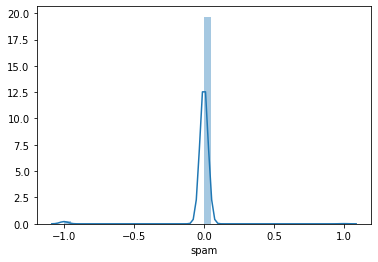

In [26]:
pred=log_model.predict(x_test)

res=pred-y_test
sb.distplot(res)

In [27]:
log_acc=metrics.accuracy_score(y_test,pred)
print('Accuracy: '+str(log_acc))
print('Precision: '+str(metrics.precision_score(y_test,pred)))
print('Recall: '+str(metrics.recall_score(y_test,pred)))

Accuracy: 0.9832535885167464
Precision: 0.9897959183673469
Recall: 0.8818181818181818


In [28]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1452
           1       0.99      0.88      0.93       220

    accuracy                           0.98      1672
   macro avg       0.99      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



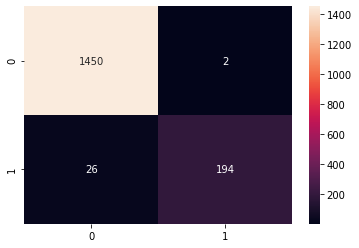

In [29]:
confuse=metrics.confusion_matrix(y_test,pred)
sb.heatmap(confuse,annot=True,fmt="g")

**Model with Logistic Regression is identifying 1644 messages correctly out of 1672. Good Results**

**Identified 194 out of 220 messages as 'spam'**<br>
**Identified 1450 out of 1452 messages as 'ham'**

In [30]:
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
print("Area under the ROC curve : " + str(roc_auc))

Area under the ROC curve : 0.9402203856749312


**Decision Tree**

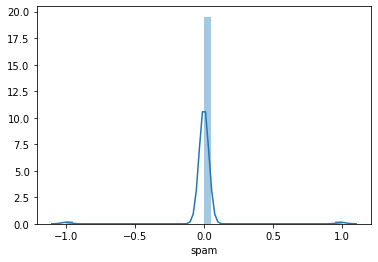

In [31]:
pred=dt_model.predict(x_test)

res=pred-y_test
sb.distplot(res)

**Looks like like we have very less errors in prediction, but model is performing good**

In [32]:
dt_acc=metrics.accuracy_score(y_test,pred)
print('Accuracy: '+str(dt_acc))
print('Precision: '+str(metrics.precision_score(y_test,pred)))
print('Recall: '+str(metrics.recall_score(y_test,pred)))

Accuracy: 0.9760765550239234
Precision: 0.9128440366972477
Recall: 0.9045454545454545


In [33]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1452
           1       0.91      0.90      0.91       220

    accuracy                           0.98      1672
   macro avg       0.95      0.95      0.95      1672
weighted avg       0.98      0.98      0.98      1672



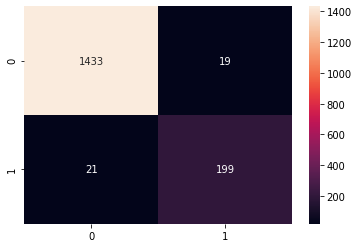

In [34]:
confuse=metrics.confusion_matrix(y_test,pred)
sb.heatmap(confuse,annot=True,fmt="g")

**Model with Decision Tree is identifying 1628 messages correctly out of 1672**

**Identified 196 out of 220 messages as 'spam'**<br>
**Identified 1432 out of 1452 messages as 'ham'**

In [35]:
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
print("Area under the ROC curve : " + str(roc_auc))

Area under the ROC curve : 0.9457300275482092


**SVM**

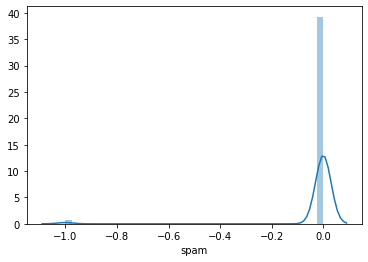

In [36]:
pred=svc_model.predict(x_test)

res=pred-y_test
sb.distplot(res)

In [37]:
svm_acc=metrics.accuracy_score(y_test,pred)
print('Accuracy: '+str(svm_acc))
print('Precision: '+str(metrics.precision_score(y_test,pred)))
print('Recall: '+str(metrics.recall_score(y_test,pred)))

Accuracy: 0.9820574162679426
Precision: 1.0
Recall: 0.8636363636363636


In [38]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1452
           1       1.00      0.86      0.93       220

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672



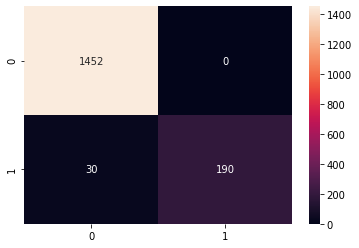

In [39]:
confuse=metrics.confusion_matrix(y_test,pred)
sb.heatmap(confuse,annot=True,fmt="g")

**Model with Decision Tree is identifying 1642 messages correctly out of 1672**

**Identified 190 out of 220 messages as 'spam'**<br>
**Identified 1452 out of 1452 messages as 'ham'**

In [40]:
fpr, tpr, _ = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
print("Area under the ROC curve : " + str(roc_auc))

Area under the ROC curve : 0.9318181818181819


In [41]:
print('**Accuracy Summary**')

print('Logistic Regression: '+str(log_acc*100)+' %')
print('Decision Tree: '+str(dt_acc*100)+' %')
print('SVM: '+str(svm_acc*100)+' %')

**Accuracy Summary**
Logistic Regression: 98.32535885167464 %
Decision Tree: 97.60765550239235 %
SVM: 98.20574162679426 %


# Conclusion

* Data is imbalanced as we have more ham messages than spam messages
* We are classifying messages are spam or not.
* Logistic Regression has more accuracy than the two algorithims, but SVM predicted all ham 'messages' accuratley without any error which is the bussiness need of entire classification.
* Decission Tree performed the worst as compared to other two algorithms.
* Though precision score of svm the great, same cann't be said about recall, which is acceptable with this kind of data.

**Let's try to identify messages using SVM**

In [42]:
def spam_filter(message):
    if svc_model.predict(v.transform([preprocess(message,'stem')]).toarray()):
        return 'spam'
    else:
        return 'not spam'

In [43]:
spam_filter("FREE entry into our £250 weekly comp just send the word WIN to 80086 NOW.")

'spam'

In [44]:
spam_filter("Machine Learning is Fun")

'not spam'